<a href="https://colab.research.google.com/github/RiceWater/New-Thesis-KFold-3CLS/blob/No-Building/Kaggle_3CLS_No_Building.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.9.3
aiosignal                        1.3.1
alabaster                        0.7.16
albumentations                   1.3.1
altair                           4.2.2
annotated-types                  0.6.0
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array_record                     0.5.1
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.1.0
attrs                            23.2.0
audioread                        3.0.1
autograd                         1.6.2
Babel                            2.14.0
backcall                         0.2.0
beautifulsoup4                   4.12.3


In [2]:
!pip uninstall jax -y

Found existing installation: jax 0.4.26
Uninstalling jax-0.4.26:
  Successfully uninstalled jax-0.4.26


In [3]:
!pip install tensorflow==2.15.0

In [4]:
!python --version

Python 3.10.12


In [5]:
!pip install image_to_numpy==1.0.0

  Preparing metadata (setup.py) ... done
  Created wheel for image_to_numpy: filename=image_to_numpy-1.0.0-py3-none-any.whl size=3456 sha256=c3deb7b7914856f7d2710ced979b387ac13f4b723c9ee210a707cdf3e4a5fab3
  Stored in directory: /root/.cache/pip/wheels/4c/e5/7e/f10f47129bb75abc8cd52a8abbff926b4a6121990f926cfe6d
Successfully built image_to_numpy


In [6]:
!pip install neptune==1.9.1 neptune-tensorflow-keras==2.2.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 495.5/495.5 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 41.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.2/82.2 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 9.5 MB/s eta 0:00:00
  Created wheel for bravado-core: filename=bravado_core-6.1.1-py2.py3-none-any.whl size=67672 sha256=1ed9cb848046d8e5c87262e0367bbfddcf91e0f85b25779ee0b25c5301fe7af3
  Stored in directory: /root/.cache/pip/wheels/42/35/4a/44ec

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import tqdm
import os
import cv2
import imghdr
import image_to_numpy
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime
import itertools
from numpy.random import default_rng

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomContrast, RandomBrightness, Rescaling, Resizing
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, ReLU
from tensorflow.keras.metrics import F1Score, Precision, Recall, CategoricalAccuracy
from tensorboard.plugins.hparams import api as hp
import sklearn
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import StratifiedKFold

from time import perf_counter
import math

import neptune
from neptune.integrations.tensorflow_keras import NeptuneCallback

In [9]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Chua_Thesis/4-600-Dataset'):
    print(os.path.join(dirname))




/content/drive/MyDrive/Chua_Thesis/4-600-Dataset
/content/drive/MyDrive/Chua_Thesis/4-600-Dataset/Road
/content/drive/MyDrive/Chua_Thesis/4-600-Dataset/Vehicle
/content/drive/MyDrive/Chua_Thesis/4-600-Dataset/Plant
/content/drive/MyDrive/Chua_Thesis/4-600-Dataset/Building


In [10]:
def make_model(params):
    model = Sequential()
    model.add(RandomFlip(mode='horizontal', seed=1, input_shape=(256,256,3)))
    model.add(RandomRotation(factor=0.2, seed=1))

    model.add(Conv2D(input_shape=(256,256,3), filters=16, kernel_size=(3,3), padding="same"))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPooling2D())

    model.add(Conv2D(filters=16, kernel_size=(3,3), padding="same"))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPooling2D())

    model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same"))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPooling2D())

    model.add(Flatten())
    model.add(Dropout(0.2, seed=1))
    model.add(Dense(units=128,activation="relu"))
    model.add(Dense(units=64,activation="relu"))

    model.add(Dense(units=3, activation="softmax"))


    optimizer = tf.keras.optimizers.Adam(
        learning_rate=params["lr"],
    )

    model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [11]:
def create_callbacks(counter):
    neptune_cbk = NeptuneCallback(run=run, base_namespace="training")

    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path + str(counter),
                                                                 monitor='val_loss',
                                                                 mode='auto',
                                                                 save_best_only=True,
                                                                 verbose=1)
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                   patience=15,
                                                  )
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                         factor=0.6,
                                                         patience=5,
                                                         min_delta=0.001,
                                                         mode='auto',
                                                         verbose=1)
#     return [reduce_lr, cp_callback, es_callback]
    return [neptune_cbk, reduce_lr, cp_callback, es_callback]

In [12]:
def plot_loss(hist):
    fig = plt.figure(figsize=(3,2))
    plt.plot(hist.history['loss'], color='teal', label='loss')
    plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
    plt.suptitle('Loss')
    plt.legend(loc='upper right')
    plt.show()
    return fig

def plot_acc(hist):
    fig = plt.figure(figsize=(3,2))
    plt.plot(hist.history['accuracy'], color='teal', label='acc')
    plt.plot(hist.history['val_accuracy'], color='orange', label='val_acc')
    plt.suptitle('Accuracy')
    plt.legend(loc='upper left')
    plt.show()
    return fig

def avg_rate(metric_list):
    return sum(metric_list) / len(metric_list)

In [13]:
with tf.device('/gpu:0'):
    labels = ['Plant', 'Vehicle', 'Road']
    X_train = []
    y_train = []
    y_label_idx = []
    image_size = 256
    for i in labels:
        folderPath = os.path.join('/content/drive/MyDrive/Chua_Thesis/4-600-Dataset', i)
        for j in os.listdir(folderPath):
            img = image_to_numpy.load_image_file(os.path.join(folderPath,j))
            img = cv2.resize(img,(image_size, image_size))
            X_train.append(img)
            y_label_idx.append(labels.index(i))

In [14]:
X_train = np.array(X_train)
y_label_idx = np.array(y_label_idx)

X_train_scaled = X_train.astype(np.float32) / 255.0

In [15]:
# seed ensures that the generation are the same from local and kaggle
rng = default_rng(seed=1)

plants_test_idx = rng.choice(np.arange(0,600), size=120, replace=False)
vehicles_test_idx = rng.choice(np.arange(600,1200), size=120, replace=False)
roads_test_idx = rng.choice(np.arange(1200,1800), size=120, replace=False)
total_test_idx = np.concatenate((plants_test_idx, vehicles_test_idx, roads_test_idx), axis=None)
print(total_test_idx[:20])

[273 397 467 471 105 584 208 456  32 573 462 540 261 134 460 229 494 293
 412 515]


In [16]:
def train_test_X(X_train_scaled):
    test_x = X_train_scaled[total_test_idx]
    train_x = np.delete(X_train_scaled, total_test_idx, axis=0)
    return train_x, test_x

def train_test_y(y_label_idx):
    test_y = y_label_idx[total_test_idx]
    train_y = np.delete(y_label_idx, total_test_idx, axis=0)
    return train_y, test_y

In [17]:
train_x, holdout_x = train_test_X(X_train_scaled)
train_y, holdout_y = train_test_y(y_label_idx)

## KFOLD

In [18]:
!mkdir MODEL

In [19]:
!ls ./

drive  MODEL  sample_data


In [20]:
model_name= 'Model 3CLS-NB-4.0.1'
checkpoint_path = f'/content/MODEL/{model_name}/FOLD-'
kfold = StratifiedKFold(n_splits=8, shuffle=True, random_state=1)
project_name='New-Thesis/Kaggle-3Cls-No-Building'

[neptune] [info   ] Neptune initialized. Open in the app: offline/2649f784-ed9e-4ed8-89f7-a160465110ad


[neptune] [warning] NeptuneWarning: The following monitoring options are disabled by default in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', and 'capture_hardware_metrics'. To enable them, set each parameter to 'True' when initializing the run. The monitoring will continue until you call run.stop() or the kernel stops. Also note: Your source files can only be tracked if you pass the path(s) to the 'source_code' argument. For help, see the Neptune docs: https://docs.neptune.ai/logging/source_code/


Epoch 1/25
158/158 [==============================] - ETA: 0s - loss: 2.4572 - accuracy: 0.7190
Epoch 1: val_loss improved from inf to 1.41725, saving model to /content/MODEL/Model 3CLS-NB-4.0.1/FOLD-0
158/158 [==============================] - 12s 29ms/step - loss: 2.4572 - accuracy: 0.7190 - val_loss: 1.4172 - val_accuracy: 0.5444 - lr: 0.0010
Epoch 2/25
157/158 [============================>.] - ETA: 0s - loss: 0.4150 - accuracy: 0.8639
Epoch 2: val_loss improved from 1.41725 to 0.97680, saving model to /content/MODEL/Model 3CLS-NB-4.0.1/FOLD-0
158/158 [==============================] - 4s 26ms/step - loss: 0.4161 - accuracy: 0.8635 - val_loss: 0.9768 - val_accuracy: 0.6722 - lr: 0.0010
Epoch 3/25
156/158 [============================>.] - ETA: 0s - loss: 0.3802 - accuracy: 0.8806
Epoch 3: val_loss improved from 0.97680 to 0.43628, saving model to /content/MODEL/Model 3CLS-NB-4.0.1/FOLD-0
158/158 [==============================] - 4s 26ms/step - loss: 0.3771 - accuracy: 0.8817 - val

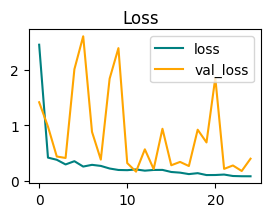

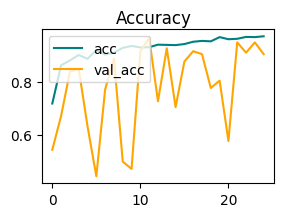

Fold Training Time: 0 hour(s) and 1 mins
Precision: 96.66666388511658  -  Recall: 96.66666388511658
Accuracy: 96.66666388511658
F1Score-P: 95.93496704101562
F1Score-R: 98.30508422851562
F1Score-V: 95.7983169555664
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/44aeeb79-6c74-40f8-9517-011cde982f9b
Epoch 1/25
155/158 [============================>.] - ETA: 0s - loss: 1.9943 - accuracy: 0.7379
Epoch 1: val_loss improved from inf to 1.82409, saving model to /content/MODEL/Model 3CLS-NB-4.0.1/FOLD-1
158/158 [==============================] - 9s 32ms/step - loss: 1.9782 - accuracy: 0.7373 - val_loss: 1.8241 - val_accuracy: 0.3611 - lr: 0.0010
Epoch 2/25
158/158 [==============================] - ETA: 0s - loss: 0.5402 - accuracy: 0.8524
Epoch 2: val_loss did not improve from 1.82409
158/158 [==============================] - 2s 11ms/step - loss: 0.5402 - accuracy: 0.8524 - 

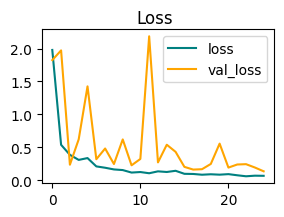

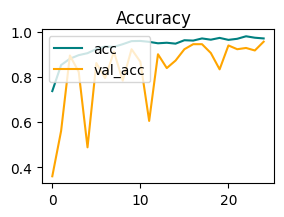

Fold Training Time: 0 hour(s) and 1 mins
Precision: 95.55555582046509  -  Recall: 95.55555582046509
Accuracy: 95.55555582046509
F1Score-P: 95.23809814453125
F1Score-R: 94.82758331298828
F1Score-V: 96.61016845703125
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/e704bdd0-560f-4928-9721-20f286411c75
Epoch 1/25
154/158 [============================>.] - ETA: 0s - loss: 1.9313 - accuracy: 0.7532
Epoch 1: val_loss improved from inf to 2.86596, saving model to /content/MODEL/Model 3CLS-NB-4.0.1/FOLD-2
158/158 [==============================] - 7s 29ms/step - loss: 1.8983 - accuracy: 0.7563 - val_loss: 2.8660 - val_accuracy: 0.4111 - lr: 0.0010
Epoch 2/25
156/158 [============================>.] - ETA: 0s - loss: 0.4261 - accuracy: 0.8662
Epoch 2: val_loss improved from 2.86596 to 1.97290, saving model to /content/MODEL/Model 3CLS-NB-4.0.1/FOLD-2
158/158 [===================

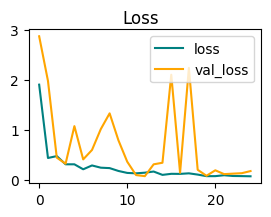

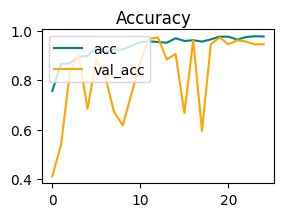

Fold Training Time: 0 hour(s) and 1 mins
Precision: 97.22222089767456  -  Recall: 97.22222089767456
Accuracy: 97.22222089767456
F1Score-P: 96.66666412353516
F1Score-R: 97.52066040039062
F1Score-V: 97.47898864746094
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/83f3f92a-2c79-43c6-afc9-31a5444afe3a
Epoch 1/25
154/158 [============================>.] - ETA: 0s - loss: 2.6900 - accuracy: 0.7459
Epoch 1: val_loss improved from inf to 4.22268, saving model to /content/MODEL/Model 3CLS-NB-4.0.1/FOLD-3
158/158 [==============================] - 8s 26ms/step - loss: 2.6340 - accuracy: 0.7500 - val_loss: 4.2227 - val_accuracy: 0.5833 - lr: 0.0010
Epoch 2/25
155/158 [============================>.] - ETA: 0s - loss: 0.6010 - accuracy: 0.8581
Epoch 2: val_loss improved from 4.22268 to 1.29381, saving model to /content/MODEL/Model 3CLS-NB-4.0.1/FOLD-3
158/158 [===================

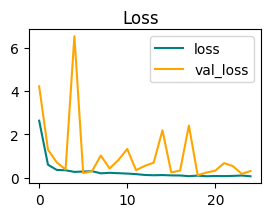

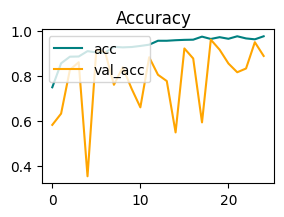

Fold Training Time: 0 hour(s) and 1 mins
Precision: 96.64804339408875  -  Recall: 96.11111283302307
Accuracy: 96.11111283302307
F1Score-P: 96.66666412353516
F1Score-R: 94.30894470214844
F1Score-V: 97.4358901977539
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/ddd3f3df-8d99-4b49-b693-d400267f51e0
Epoch 1/25
157/158 [============================>.] - ETA: 0s - loss: 1.8750 - accuracy: 0.7261
Epoch 1: val_loss improved from inf to 3.83950, saving model to /content/MODEL/Model 3CLS-NB-4.0.1/FOLD-4
158/158 [==============================] - 8s 26ms/step - loss: 1.8763 - accuracy: 0.7254 - val_loss: 3.8395 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 2/25
155/158 [============================>.] - ETA: 0s - loss: 0.4680 - accuracy: 0.8637
Epoch 2: val_loss improved from 3.83950 to 2.23241, saving model to /content/MODEL/Model 3CLS-NB-4.0.1/FOLD-4
158/158 [====================

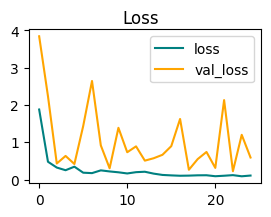

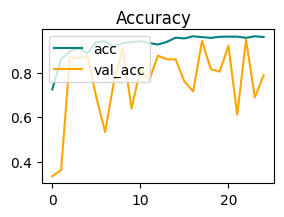

Fold Training Time: 0 hour(s) and 1 mins
Precision: 94.9999988079071  -  Recall: 94.9999988079071
Accuracy: 94.9999988079071
F1Score-P: 92.56198120117188
F1Score-R: 94.01709747314453
F1Score-V: 98.36064910888672
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/f63d1290-3999-45a2-b75b-2605e80c0417
Epoch 1/25
157/158 [============================>.] - ETA: 0s - loss: 2.4618 - accuracy: 0.7182
Epoch 1: val_loss improved from inf to 2.02975, saving model to /content/MODEL/Model 3CLS-NB-4.0.1/FOLD-5
158/158 [==============================] - 9s 33ms/step - loss: 2.4607 - accuracy: 0.7167 - val_loss: 2.0298 - val_accuracy: 0.5944 - lr: 0.0010
Epoch 2/25
154/158 [============================>.] - ETA: 0s - loss: 0.4694 - accuracy: 0.8506
Epoch 2: val_loss improved from 2.02975 to 1.49679, saving model to /content/MODEL/Model 3CLS-NB-4.0.1/FOLD-5
158/158 [======================

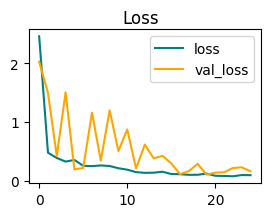

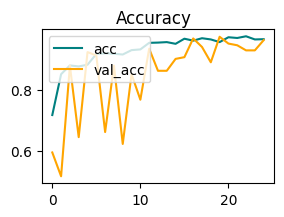

Fold Training Time: 0 hour(s) and 1 mins
Precision: 97.22222089767456  -  Recall: 97.22222089767456
Accuracy: 97.22222089767456
F1Score-P: 95.93496704101562
F1Score-R: 97.47898864746094
F1Score-V: 98.30508422851562
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/e48d6535-92c1-4643-a5da-68297faac4cb
Epoch 1/25
157/158 [============================>.] - ETA: 0s - loss: 2.2416 - accuracy: 0.7508
Epoch 1: val_loss improved from inf to 1.97854, saving model to /content/MODEL/Model 3CLS-NB-4.0.1/FOLD-6
158/158 [==============================] - 9s 39ms/step - loss: 2.2436 - accuracy: 0.7492 - val_loss: 1.9785 - val_accuracy: 0.3833 - lr: 0.0010
Epoch 2/25
156/158 [============================>.] - ETA: 0s - loss: 0.6357 - accuracy: 0.8510
Epoch 2: val_loss improved from 1.97854 to 1.25519, saving model to /content/MODEL/Model 3CLS-NB-4.0.1/FOLD-6
158/158 [===================

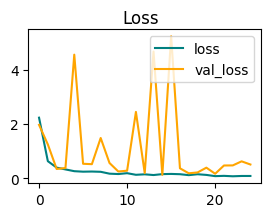

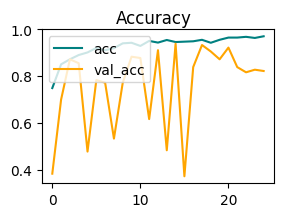

Fold Training Time: 0 hour(s) and 1 mins
Precision: 93.82022619247437  -  Recall: 92.77777671813965
Accuracy: 93.88889074325562
F1Score-P: 92.91338348388672
F1Score-R: 92.03539276123047
F1Score-V: 96.66666412353516
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/1ef9b5c3-aaf0-47f6-9672-4b7cd039697b
Epoch 1/25
157/158 [============================>.] - ETA: 0s - loss: 2.4063 - accuracy: 0.7588
Epoch 1: val_loss improved from inf to 2.21402, saving model to /content/MODEL/Model 3CLS-NB-4.0.1/FOLD-7
158/158 [==============================] - 7s 28ms/step - loss: 2.4130 - accuracy: 0.7571 - val_loss: 2.2140 - val_accuracy: 0.6056 - lr: 0.0010
Epoch 2/25
154/158 [============================>.] - ETA: 0s - loss: 0.5329 - accuracy: 0.8515
Epoch 2: val_loss improved from 2.21402 to 1.76292, saving model to /content/MODEL/Model 3CLS-NB-4.0.1/FOLD-7
158/158 [===================

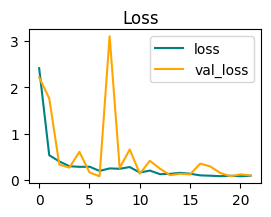

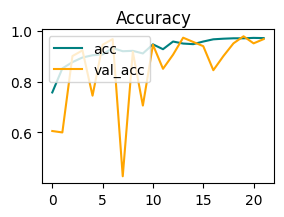

Fold Training Time: 0 hour(s) and 1 mins
Precision: 96.66666388511658  -  Recall: 96.66666388511658
Accuracy: 96.66666388511658
F1Score-P: 95.93496704101562
F1Score-R: 94.82758331298828
F1Score-V: 99.17355346679688
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
Total Training Time: 0 hour(s) and 11 mins


In [21]:
params = {
    "lr": 0.001,
    "epochs": 25,
    "batch_size": 8}

precisions = []
recalls = []
accuracies = []
f1_plant = []
f1_road = []
f1_vcl = []

with tf.device('/gpu:0'):
    counter = 0
    start = perf_counter()
    for train, test in kfold.split(train_x, train_y):
        start_fold = perf_counter()

        run = neptune.init_run(
            name= f"{model_name}-FOLD_{counter}",
            project=project_name,
            mode="offline",     # To prevent issue when internet sucks. Just manually sync it
            )  # your credentials

        run["parameters"] = params


        model = make_model(params)
        cat_y = tf.keras.utils.to_categorical(train_y)

        train_dataset = tf.data.Dataset.from_tensor_slices((train_x[train], cat_y[train]))
        train_fold = train_dataset.shuffle(buffer_size=train_dataset.cardinality(), seed=1).batch(params['batch_size'])

        test_dataset = tf.data.Dataset.from_tensor_slices((train_x[test], cat_y[test]))
        test_fold = test_dataset.shuffle(buffer_size=test_dataset.cardinality(), seed=1).batch(params['batch_size'])

        hist = model.fit(train_fold,
                         validation_data=test_fold,
                         batch_size=params['batch_size'],
                         epochs=params['epochs'],
                         verbose=1,
                         callbacks=create_callbacks(counter))
        end_fold = perf_counter()

        # PLOTTING ==================================================
        run["fig-train_loss"].upload(plot_loss(hist))
        run["fig-train_acc"].upload(plot_acc(hist))

        # EVALUATING ==================================================
        model = tf.keras.models.load_model(checkpoint_path + str(counter))

        pre = Precision()
        rec = Recall()
        c_acc = CategoricalAccuracy()
        f1_score = F1Score()
        for batch in test_fold.as_numpy_iterator():
            X, y = batch
            yhat = model.predict(X, verbose=0)
            pre.update_state(y, yhat)
            rec.update_state(y, yhat)
            c_acc.update_state(y, yhat)
            f1_score.update_state(y, yhat)


        precisions.append(pre.result().numpy() * 100)
        recalls.append(rec.result().numpy() * 100)
        accuracies.append(c_acc.result().numpy() * 100)
        f1_s = f1_score.result().numpy() * 100

        f1_plant.append(f1_s[0])
        f1_vcl.append(f1_s[1])
        f1_road.append(f1_s[2])

        run["eval/ACC/"] = accuracies[counter]
        run["eval/REC/"] = recalls[counter]
        run["eval/PRE/"] = precisions[counter]
        run["eval/F1-P"] = f1_plant[counter]
        run["eval/F1-R"] = f1_road[counter]
        run["eval/F1-V"] = f1_vcl[counter]

        # SAVE MODEL TO NEPTUNE AI =======================================
        model_save_path = f'{checkpoint_path}{counter}/{model_name}-FOLD-{counter}.keras'
        model.save(model_save_path)
        run['checkpoint/model'].upload(model_save_path)

        # PRINTING RESULTS ===========================================
        print(f'Fold Training Time: {math.floor((end_fold-start_fold)/3600) } hour(s) and {math.floor((end_fold-start_fold)/60)%60} mins')
        print(f'Precision: {precisions[counter]}  -  Recall: {recalls[counter]}')
        print(f'Accuracy: {accuracies[counter]}')
        print(f'F1Score-P: {f1_plant[counter]}')
        print(f'F1Score-R: {f1_road[counter]}')
        print(f'F1Score-V: {f1_vcl[counter]}')

        run.stop()

        counter += 1

    end = perf_counter()
    print(f'Total Training Time: {math.floor((end-start)/3600) } hour(s) and {math.floor((end-start)/60)%60} mins')

In [22]:
print(f"""
Avg Accuracy: {avg_rate(accuracies)}
Avg Precision: {avg_rate(precisions)}
Avg Recall: {avg_rate(recalls)}
Avg F1-Score-P: {avg_rate(f1_plant)}
Avg F1-Score-R: {avg_rate(f1_road)}
Avg F1-Score-V: {avg_rate(f1_vcl)}
""")


Avg Accuracy: 96.04166597127914
Avg Precision: 96.1001992225647
Avg Recall: 95.90277671813965
Avg F1-Score-P: 95.23146152496338
Avg F1-Score-R: 95.4151668548584
Avg F1-Score-V: 97.47866439819336



In [23]:
run = neptune.init_run(
            name= f"{model_name}-AVG",
            project=project_name,
            mode="offline",     # To prevent issue when internet sucks. Just manually sync it
            )

run["eval/PRE/"] = avg_rate(precisions)
run["eval/REC/"] = avg_rate(recalls)
run["eval/ACC/"] = avg_rate(accuracies)
run["eval/F1-P"] = avg_rate(f1_plant)
run["eval/F1-R"] = avg_rate(f1_road)
run["eval/F1-V"] = avg_rate(f1_vcl)

run.stop()

[neptune] [info   ] Neptune initialized. Open in the app: offline/751ea1bb-8c1a-49b9-b578-58e8c4ee5657
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!


In [24]:
os.environ['NEPTUNE_API_TOKEN'] = "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJiM2YzNGEwOC1iNmYyLTQ3YTEtYTljNi0xOWNmYWE0ZjZjOTMifQ=="

In [25]:
!neptune sync -p 'New-Thesis/Kaggle-3Cls-No-Building' --offline-only


Offline container 9bd5846f-7d92-49f2-9700-05d531eedf13 registered as New-Thesis/Kaggle-3Cls-No-Building/K3NB-7
Synchronising New-Thesis/Kaggle-3Cls-No-Building/K3NB-7
Deleted: /content/.neptune/async/run__9bd5846f-7d92-49f2-9700-05d531eedf13__11859__fdnopd31
Synchronization of run New-Thesis/Kaggle-3Cls-No-Building/K3NB-7 completed.
Offline container 9bd58477-b744-4885-8dc3-f9b42764c85c registered as New-Thesis/Kaggle-3Cls-No-Building/K3NB-8
Synchronising New-Thesis/Kaggle-3Cls-No-Building/K3NB-8
Deleted: /content/.neptune/async/run__9bd58477-b744-4885-8dc3-f9b42764c85c__11859__7y9k4tlu
Synchronization of run New-Thesis/Kaggle-3Cls-No-Building/K3NB-8 completed.
Offline container 9bd5847f-4a58-4abc-a42f-f21bff0e6402 registered as New-Thesis/Kaggle-3Cls-No-Building/K3NB-9
Synchronising New-Thesis/Kaggle-3Cls-No-Building/K3NB-9
Deleted: /content/.neptune/async/run__9bd5847f-4a58-4abc-a42f-f21bff0e6402__11859__qgg1b5gh
Synchronization of run New-Thesis/Kaggle-3Cls-No-Building/K3NB-9 comple

In [26]:
!neptune clear


In [27]:
!rm -r "/content/MODEL/Model 3CLS-NB-4.0.1"

## Extract Model Checkpoint
- Download model from neptune AI
- Upload here
- change path and names and run code

In [ ]:
sm = tf.keras.models.load_model("/content/model.keras")


In [ ]:
FIX-MODEL-NAME

sm.save_weights("./checkpoints/test_model")


In [ ]:
!zip -r test.zip "./checkpoints"